# Template Pipeline
Normalisation&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**-**  
Imputation 1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Median**  
Outlier Detection&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Z Score**  
Imputation 2&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Median**  
Feature Selection&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Implicit to model**  
Model&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Lasso Regression**


## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# General
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ML
from sklearn.linear_model import LinearRegression, Lasso, BayesianRidge, LassoLarsCV, LassoCV, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression, RFE, RFECV
from sklearn.cluster import FeatureAgglomeration

#from sklearn.preprocessing import StandardScaler
import xgboost as xgb


# Custom
import sys,os
# %cd /content/gdrive/My Drive/ETHZ/Autumn2020/AML/Git/AML/Task_1/Solution
# sys.path.append('/content/gdrive/My Drive/ETHZ/Autumn2020/AML/Git/AML/Task_1/Solution')
sys.path.append('/home/jovyan/work/AML/Task_1/Solution') # I would like a cleaner solution but works for now
import Components.Imputation as Imputation
import Components.Outlier_Detection_1D as Outlier_Detection_1D
import Components.Outlier_Detection_ND as Outlier_Detection_ND
import Components.Feature_Selection as Feature_Selection
import Components.Normalisation as Normalisation
import Components.data_fetching as data_fetching

# CAREFUL:
# If you make changes to a custom module, you have to reload it, i.e rerun this cell
import importlib
importlib.reload(Imputation)
importlib.reload(Outlier_Detection_1D)
importlib.reload(Outlier_Detection_ND)
importlib.reload(Feature_Selection)
importlib.reload(Normalisation)
importlib.reload(data_fetching)

<module 'Components.data_fetching' from '/home/jovyan/work/AML/Task_1/Solution/Components/data_fetching.py'>

## Data Cleaning

### Data import

In [ ]:
x_train, y_train = data_fetching.get_train_data()
x_test = data_fetching.get_test_data()


### First (simple) imputation

In [ ]:
print("Missing values before simple median imputation: ")
print(x_train.isnull().sum().sum())
missing_values = Imputation.missing_values_mask(x_train)

x_train = Imputation.median(x_train, x_test)

print("Missing values after simple median imputation: ")
print(x_train.isnull().sum().sum())

Missing values before simple median imputation: 
76910
Missing values after simple median imputation: 
0


### Normalisation 

In [ ]:
x_train = Normalisation.gaussian(x_train)
x_test = Normalisation.gaussian(x_test)

### Outlier detection

one-dimensional

In [ ]:
x_train = Outlier_Detection_1D.z_score(x_train,x_test)

print("Missing values after outlier detection: ")
print(x_train.isnull().sum().sum())

Missing values after outlier detection: 
1230


multivariate

In [ ]:
x_train, y_train, missing_values = Outlier_Detection_ND.magic_indices(x_train,y_train,n_outliers=50, mask=missing_values)
## hp

### Second (more sophisticated) Imputation

In [ ]:
x_train = x_train.mask(missing_values)
print("Missing values after applying the missing value mask: ")
print(x_train.isnull().sum().sum())

x_train, x_test = Imputation.iterative_regression2(x_train,x_test) #hp


print("Missing values after second round of imputation: ")
print(x_train.isnull().sum().sum())


Missing values after applying the missing value mask: 
74960
/opt/venv/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
Missing values after second round of imputation: 
0


In [ ]:
network = pd.DataFrame(x_train).corr('spearman').abs()>0.9

In [ ]:
print(network)

         x0     x1     x2     x3     x4     x5     x6     x7     x8     x9  \
x0     True  False  False  False  False  False  False  False  False  False   
x1    False   True  False  False  False  False  False  False  False  False   
x2    False  False   True  False  False  False  False  False  False  False   
x3    False  False  False   True  False  False  False  False  False  False   
x4    False  False  False  False   True  False  False  False  False  False   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
x827  False  False  False  False  False  False  False  False  False  False   
x828  False  False  False  False  False  False  False  False  False  False   
x829  False  False  False  False  False  False  False  False  False  False   
x830  False  False  False  False  False  False  False  False  False  False   
x831  False  False  False  False  False  False  False  False  False  False   

      ...   x822   x823   x824   x825   x826   x827   x828   x8

In [ ]:
!pip install networkx==2.5

     |████████████████████████████████| 1.6 MB 5.9 MB/s eta 0:00:01     |█▉                              | 92 kB 9.0 MB/s eta 0:00:01
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import networkx as nx

In [ ]:
network = nx.Graph(network)
cliques = list(nx.find_cliques(network))
feat_sel = [item[0] for item in cliques]
print(feat_sel)

None


In [ ]:
x_train_sel = x_train[feat_sel]
x_test_sel = x_test[feat_sel] 
print(x_train_sel.head())
print(x_test_sel.head())

         x0        x1       x10      x100      x102      x103      x104  \
0  0.983660 -1.797981 -1.431555  0.227549  0.820887  0.048516  0.205170   
1  1.574496  1.314327  1.100632  1.053122 -0.673468 -0.231434  2.131083   
2  1.163787  1.222372  0.527413 -0.650393  0.508424 -0.689450  0.160700   
3  1.730883 -0.016872  1.529126  0.232667  1.684616 -0.502396 -0.337603   
4  0.465330 -0.872474  1.437803 -1.437433  0.629752 -0.773913 -0.128134   

       x105      x106      x107  ...       x89        x9       x90       x92  \
0 -0.284533 -0.327327 -0.921582  ...  0.528415 -0.719773  0.002425  1.311683   
1 -1.067571 -1.046316 -0.913863  ... -0.345793  0.983987 -0.836048  1.389854   
2 -0.344499 -1.087430  1.544614  ...  1.263114 -0.145852  1.067571  1.191360   
3  0.327998 -0.504981  1.408681  ...  1.291389  0.871677 -1.230190  1.431722   
4  0.475009  0.463633  0.249356  ...  0.336874 -1.065402  0.736069  0.544377   

        x94       x95       x96       x97       x98       x99  
0 -1

In [ ]:
network = pd.DataFrame(x_train).corr('spearman').abs()>0.9 #could be varied
network = nx.Graph(network)
cliques = list(nx.find_cliques(network))
feat_sel = [item[0] for item in cliques]
x_train= x_train[feat_sel]
x_test= x_test[feat_sel] 

In [ ]:
print(x_train)

           x79      x133      x245      x717      x660      x497      x605  \
0     0.545734 -1.617460 -0.229541 -1.350738 -0.299368 -0.006527  1.127280   
1    -0.201829  1.611893  0.363125 -1.404061 -0.482874 -2.057470  2.019842   
2    -0.740728 -1.309958 -0.878368  0.634268 -0.631007 -0.323110 -0.534290   
3     0.200211  0.950356  0.922227  0.874973 -0.503883 -2.416634  0.340552   
4     0.780829  0.424272  1.940598  1.552437 -0.950532  1.398569  0.821787   
...        ...       ...       ...       ...       ...       ...       ...   
1157 -0.203025  0.112019  0.065468  1.821255  1.357727  1.336744  1.437184   
1158 -1.067571  0.271720 -1.743861  0.613749  0.016361 -1.490033 -0.807205   
1159 -0.550557 -0.356192  1.383340 -1.203816  0.980917 -0.733108 -1.130855   
1160 -0.838710 -0.908337  0.631661  0.360990 -2.650656 -0.836644 -0.465856   
1161  0.294575 -1.752633  0.495299  0.341802  2.044230 -0.006557  1.580476   

          x547      x257      x436  ...      x102      x332    

## Feature selection and Model Training

In [ ]:


#pipe = Pipeline([('feature_selection', SelectFromModel(LassoLarsCV())),('regressor', AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
  #                        n_estimators=300))])

#pipe = Pipeline([('feature_selection1',SelectKBest(mutual_info_regression, k=200)),('feature_selection2', SelectFromModel(LassoLarsCV())),
#('regressor', GradientBoostingRegressor(n_estimators=100))])

# hp: which method to choose for feature selection and regression

#pipe = Pipeline([('feature_selection1',SelectKBest(mutual_info_regression, k=400)),
 #   ('dimensionality reduction', FeatureAgglomeration(n_clusters=100)),
  #  ('feature_selection2',SelectKBest(mutual_info_regression, k=40)),
   # ('regressor', GradientBoostingRegressor(n_estimators=100))])

In [ ]:
fsel =RFE(Ridge(),n_features_to_select=50)
x_sel = fsel.fit_transform(x_train,y_train)



AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [ ]:
x_sel = pd.DataFrame(x_sel)
print(x_sel.corr('spearman')>0.9)

       0      1      2      3      4      5      6      7      8      9   ...  \
0    True  False  False  False  False  False  False  False  False  False  ...   
1   False   True  False  False  False  False  False  False  False  False  ...   
2   False  False   True  False  False  False  False  False  False  False  ...   
3   False  False  False   True  False  False  False  False  False  False  ...   
4   False  False  False  False   True  False  False  False  False  False  ...   
5   False  False  False  False  False   True  False  False  False  False  ...   
6   False  False  False  False  False  False   True  False  False  False  ...   
7   False  False  False  False  False  False  False   True  False  False  ...   
8   False  False  False  False  False  False  False  False   True  False  ...   
9   False  False  False  False  False  False  False  False  False   True  ...   
10  False  False  False  False  False  False  False  False  False  False  ...   
11  False  False  False  Fal

In [ ]:
#pipe = Pipeline([('feature_selection', RFE(Ridge(),n_features_to_select=50)),
 #   ('regressor', GradientBoostingRegressor(n_estimators=100))])

#pipe = Pipeline([('feature_selection', RFE(Ridge(),n_features_to_select=50)),
 #   ('regressor', xgb.XGBRegressor())])

pipe = Pipeline([('feature_selection', RFE(Ridge(), n_features_to_select=50)),
    ('regressor', xgb.XGBRegressor(max_depth=5, n_estimators=200, learning_rate=0.05, alpha=1, objective='reg:squarederror'))])

In [ ]:
# Model parameters
# max_depth = [2,3,4]
learning_rate = [0.05, 0.1,0.2]
n_estimators = [100, 200]

parameters = dict(normalise__n_quantiles=n_quants,
                    # impute__n_nearest_features=n_nearest_features,
                    feature_select__n_features_to_select=n_features,
                    regress__learning_rate=learning_rate,
                    regress__n_estimators=n_estimators)

clf = GridSearchCV(pipe, parameters)
clf.fit(X, y)

# View The Best Parameters
print('n_quantiles=', clf.best_estimator_.get_params()['normalise__n_quantiles'])
# print('n_nearest_features=', clf.best_estimator_.get_params()['impute__n_nearest_features'])
print('n_features_to_select=', clf.best_estimator_.get_params()['feature_select__n_features_to_select'])
print('learning_rate=', clf.best_estimator_.get_params()['regress__learning_rate'])
print('n_estimators=', clf.best_estimator_.get_params()['regress__n_estimators'])
best_n_quantiles= clf.best_estimator_.get_params()['normalise__n_quantiles']
# best_n_nearest_features= clf.best_estimator_.get_params()['impute__n_nearest_features']
best_n_features_to_select= clf.best_estimator_.get_params()['feature_select__n_features_to_select']
best_learning_rate= clf.best_estimator_.get_params()['regress__learning_rate']
best_n_estimators= clf.best_estimator_.get_params()['regress__n_estimators']

### Cross Validation

In [ ]:
scores = cross_val_score(pipe, x_train, np.ravel(y_train), cv=5, scoring='r2')
print(scores)
print(np.mean(scores))

KeyboardInterrupt: 

## Final Prediction

In [ ]:
pipe.fit(x_train, np.ravel(y_train))


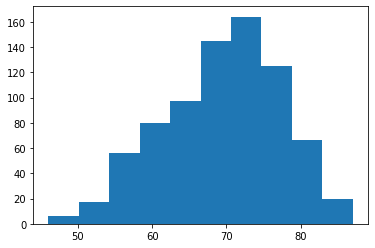

In [ ]:

# Note: They said no outliers were introduced in x_test so no need to perform outlier detection
y_pred = pipe.predict(x_test)
plt.hist(y_pred)

y_pred_pd = pd.DataFrame(data=y_pred, columns=["y"])
y_pred_pd.to_csv('../../Predictions/RFE50_xgb_deep_magic50_tuned.csv', index_label='id')

In [ ]:
pipe.named_steps

{'feature_selection': RFE(estimator=Ridge(), n_features_to_select=100),
 'regressor': GradientBoostingRegressor()}